# Experiment 2 Notebook



In [136]:
import nltk
from jiwer import wer
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob


# NLTK's VADER
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# FLAIR's en-sentiment
from flair.models import TextClassifier
from flair.data import Sentence
flair_sent = TextClassifier.load('en-sentiment')


from sentence_transformers import SentenceTransformer, util
minilm = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# bert nli is said to be depreciated
bert_nli = SentenceTransformer('bert-base-nli-mean-tokens')
mpnet = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
distil_roberta = SentenceTransformer('sentence-transformers/all-distilroberta-v1')


2023-01-17 12:08:53,199 loading file /Users/ryanwhetten/.flair/models/sentiment-en-mix-distillbert_4.pt


In [151]:
# df = pd.read_pickle('measures_df.pkl')
asr_df = pd.read_csv('AllASRTrans.csv')

asr_df = asr_df.dropna()
# asr_df = asr_df.fillna('')


In [152]:
# Clean text
asr_df.Correct = asr_df.Correct.str.replace('\n', '', regex=False)
asr_df.Correct = asr_df.Correct.str.replace('D:', '', regex=False)
asr_df.Correct = asr_df.Correct.str.replace('P:', '', regex=False)

asr_df.Correct = asr_df.Correct.str.replace(r'[^\w\s\']+', '', regex=True)
asr_df.Correct = asr_df.Correct.str.lower()

asr_df.Vosk = asr_df.Vosk.str.replace(r'[^\w\s\']+', '', regex=True)
asr_df.Vosk = asr_df.Vosk.str.lower()

asr_df.PocketSphinx = asr_df.PocketSphinx.str.replace(r'[^\w\s\']+', '', regex=True)
asr_df.PocketSphinx = asr_df.PocketSphinx.str.lower()

asr_df.Whisper = asr_df.Whisper.str.replace(r'[^\w\s\']+', '', regex=True)
asr_df.Whisper = asr_df.Whisper.str.lower()

asr_df.DeepSpeech2 = asr_df.DeepSpeech2.str.replace(r'[^\w\s\']+', '', regex=True)
asr_df.DeepSpeech2 = asr_df.DeepSpeech2.str.lower()

asr_df.Wav2Vec2 = asr_df.Wav2Vec2.str.replace(r'[^\w\s\']+', '', regex=True)
asr_df.Wav2Vec2 = asr_df.Wav2Vec2.str.lower()

# get pairs
pairs_v = list(zip(asr_df.Correct, asr_df.Vosk))
pairs_ps = list(zip(asr_df.Correct, asr_df.PocketSphinx))
pairs_wh = list(zip(asr_df.Correct, asr_df.Whisper))
pairs_ds = list(zip(asr_df.Correct, asr_df.DeepSpeech2))
pairs_wv = list(zip(asr_df.Correct, asr_df.Wav2Vec2))


In [153]:
asr_df.head()

,File,Correct,Vosk,PocketSphinx,Whisper,DeepSpeech2,Wav2Vec2
0,CAR0001_0002,sure thirty nine i'm a male,sure i'm thirty nine i'm a male,sure how the ninth and i'm in l,sure 39 i'm a male,sure thirty nine a a male,sharp am thirty nine ah i'm a male
1,CAR0001_0005,start,start,stairs,start,start,start
2,CAR0001_0006,uhm it started last night,and it started last night,and it it's there in the last night,it started last night,and it started last night,and it started last night
3,CAR0001_0007,but it's becoming sharper,i have but it's becoming sharper,abbott's an instructor,but it's becoming sharper,but it's the coming sharper,ah but it's the coming sharper
4,CAR0001_0008,ok and where is this pain located,okay and i where is the pain located,okay stands out where is is being loaded,okay and where is this pain located,okay and i where is this pain located,o ka and a were is this pain located


In [154]:
pairs_wh[:3]

[("sure thirty nine i'm a male", " sure 39 i'm a male"),
 ('start', 'start'),
 ('uhm it started last night', 'it started last night')]

In [155]:
def get_dif_sent(s, s1):
    return sia.polarity_scores(s)['compound'] - sia.polarity_scores(s1)['compound']

def get_cos_dis(s, s1, model):
    embedding_s = model.encode(s, convert_to_tensor=True)
    embedding_s1 = model.encode(s1, convert_to_tensor=True)
    return util.pytorch_cos_sim(embedding_s, embedding_s1)

def flair_get_sent_score(s):
    sent = Sentence(s)
    flair_sent.predict(sent)
    lab = sent.get_label()
    if lab.value == "NEGATIVE": 
        return lab.score * -1
    else: 
        return lab.score
    
def get_dif_sent_flair(s, s1):
    v1 = flair_get_sent_score(s)
    v2 = flair_get_sent_score(s1)
    return v1 - v2

def get_dif_sent_tb(s, s1):
    sblob = TextBlob(s)
    s1blob = TextBlob(s1)
    return sblob.sentiment.polarity - s1blob.sentiment.polarity

In [156]:
def get_measures_df(pairs):
    measures = []

    for pair in pairs:
        word_err = wer(pair[0], pair[1])

        # nltk vader sentiment
        dif_sent = np.abs(get_dif_sent(pair[0], pair[1]))
        dif_sent_2 = dif_sent ** 2

        # flair sentiment
        flair_dif_sent = np.abs(get_dif_sent_flair(pair[0], pair[1]))
        flair_dif_sent_2 = flair_dif_sent**2

        # textblob sentiment
        tb_dif_sent = np.abs(get_dif_sent_tb(pair[0], pair[1]))
        tb_dif_sent_2 = tb_dif_sent**2


        minilm_score = 1 - get_cos_dis(pair[0], pair[1], minilm).item()
        bert_nli_score = 1 - get_cos_dis(pair[0], pair[1], bert_nli).item()
        mpnet_score = 1 - get_cos_dis(pair[0], pair[1], mpnet).item()
        dr_score = 1 - get_cos_dis(pair[0], pair[1], distil_roberta).item()    


        measures.append([pair, word_err, 
                         dif_sent, 
    #                      dif_sent_2, 
                         flair_dif_sent, 
    #                      flair_dif_sent_2,
                         tb_dif_sent, 
    #                      tb_dif_sent_2,
                         minilm_score, bert_nli_score, mpnet_score, dr_score])


    measures_df = pd.DataFrame(measures, columns =['pairs', 'WER', 'NLTK_DS', 'FLAIR_DS', 'TB_DS', 
                                                   'MiniLM', 'BertNLI', 'MPNET', 'DisRob'], 
                               dtype = float)
    return measures_df


In [157]:
measures_v = get_measures_df(pairs_v)
measures_ps = get_measures_df(pairs_ps)
measures_wh = get_measures_df(pairs_wh)
measures_ds = get_measures_df(pairs_ds)
measures_wv = get_measures_df(pairs_wv)

# pairs_v = list(zip(asr_df.Correct, asr_df.Vosk))
# pairs_ps = list(zip(asr_df.Correct, asr_df.PocketSphinx))
# pairs_wh = list(zip(asr_df.Correct, asr_df.Whisper))
# pairs_ds = list(zip(asr_df.Correct, asr_df.DeepSpeech2))
# pairs_wv = list(zip(asr_df.Correct, asr_df.Wav2Vec2))

/var/folders/45/q82ywkcn7fnbcgzp5x_lv4880000gn/T/ipykernel_28540/421701048.py:36: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
/var/folders/45/q82ywkcn7fnbcgzp5x_lv4880000gn/T/ipykernel_28540/421701048.py:36: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
/var/folders/45/q82ywkcn7fnbcgzp5x_lv4880000gn/T/ipykernel_28540/421701048.py:36: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
/var/folders/45/q82ywkcn7fnbcgzp5x_lv4880000gn/T/ipyker

In [158]:
measures_v.head()
# measures_ps.head()
# measures_wh.head()
# measures_ds.head()
# measures_wv.head()

,pairs,WER,NLTK_DS,FLAIR_DS,TB_DS,MiniLM,BertNLI,MPNET,DisRob
0,"(sure thirty nine i'm a male, sure i'm thirty ...",0.166667,0.000,0.000267,0.0,0.067201,3.870517e-02,7.953924e-02,3.197885e-02
1,"(start, start)",0.000000,0.000,0.000000,0.0,0.000000,1.192093e-07,-3.576279e-07,-2.384186e-07
2,"(uhm it started last night, and it started las...",0.200000,0.000,1.706749,0.0,0.137907,9.372473e-03,1.710131e-01,1.264330e-01
3,"(but it's becoming sharper, i have but it's be...",0.500000,0.000,0.088766,0.0,0.365367,2.809995e-02,3.525901e-01,3.149463e-01
4,"(ok and where is this pain located , okay and ...",0.428571,0.057,0.004573,0.0,0.113560,2.261573e-02,8.174193e-02,7.077980e-02


**Avg. WER**

In [159]:
wers = [np.mean(measures_ds.WER),
        np.mean(measures_ps.WER),
        np.mean(measures_v.WER), 
        np.mean(measures_wh.WER),
        np.mean(measures_wv.WER),]
wers

# [0.4854902593620484,
#  0.9119273393945999,
#  0.30818373482641814,
#  0.2770381937551604,
#  0.526362012784877]


[0.4830357285395794,
 0.9114981318190862,
 0.3076203998835564,
 0.27469096482656985,
 0.5262010599440593]

**MAE of Sent**

In [160]:
nltk = [np.mean(measures_ds.NLTK_DS), 
        np.mean(measures_ps.NLTK_DS),
        np.mean(measures_v.NLTK_DS),
        np.mean(measures_wh.NLTK_DS),
        np.mean(measures_wv.NLTK_DS),]

flair = [np.mean(measures_ds.FLAIR_DS),
         np.mean(measures_ps.FLAIR_DS),
         np.mean(measures_v.FLAIR_DS),
         np.mean(measures_wh.FLAIR_DS),
         np.mean(measures_wv.FLAIR_DS),]

tb = [np.mean(measures_ds.TB_DS), 
      np.mean(measures_ps.TB_DS),
      np.mean(measures_v.TB_DS),
      np.mean(measures_wh.TB_DS),
      np.mean(measures_wv.TB_DS),]

flair
# [0.6074389388801855,
#  0.7135182553475056,
#  0.312383773676846,
#  0.31019710564832076,
#  0.5033627874260649]

[0.6203458932561612,
 0.700611274723613,
 0.32528141113596226,
 0.32310408627221343,
 0.5162697680499575]

**MSE of Sent**

In [161]:
mse_nltk = [np.mean(measures_ds.NLTK_DS**2), 
        np.mean(measures_ps.NLTK_DS**2),
        np.mean(measures_v.NLTK_DS**2),
        np.mean(measures_wh.NLTK_DS**2),
        np.mean(measures_wv.NLTK_DS**2),]

mse_flair = [np.mean(measures_ds.FLAIR_DS**2),
         np.mean(measures_ps.FLAIR_DS**2),
         np.mean(measures_v.FLAIR_DS**2),
         np.mean(measures_wh.FLAIR_DS**2),
         np.mean(measures_wv.FLAIR_DS**2),]

mse_tb = [np.mean(measures_ds.TB_DS**2), 
        np.mean(measures_ps.TB_DS**2),
        np.mean(measures_v.TB_DS**2),
        np.mean(measures_wh.TB_DS**2),
        np.mean(measures_wv.TB_DS**2),]

mse_flair

# [0.9608862727932882,
#  1.1630808800994055,
#  0.4380252745278624,
#  0.45350460283842886,
#  0.7666978386745589]

[0.9828939857214225,
 1.1346818354698287,
 0.46067866489067466,
 0.4755123160353468,
 0.7893662852490917]

**Avg. cosine distance**

In [162]:
minilm_avg = [np.mean(measures_ds.MiniLM), 
              np.mean(measures_ps.MiniLM),
              np.mean(measures_v.MiniLM),
              np.mean(measures_wh.MiniLM),
              np.mean(measures_wv.MiniLM),]

bertnli_avg = [np.mean(measures_ds.BertNLI), 
               np.mean(measures_ps.BertNLI),
               np.mean(measures_v.BertNLI),
               np.mean(measures_wh.BertNLI),
               np.mean(measures_wv.BertNLI),]

mpnet_avg = [np.mean(measures_ds.MPNET), 
             np.mean(measures_ps.MPNET),
             np.mean(measures_v.MPNET),
             np.mean(measures_wh.MPNET),
             np.mean(measures_wv.MPNET),]

disrob_avg = [np.mean(measures_ds.DisRob), 
              np.mean(measures_ps.DisRob),
              np.mean(measures_v.DisRob),
              np.mean(measures_wh.DisRob),
              np.mean(measures_wv.DisRob),]


In [163]:
summary = {
    'WER': wers,
    
    'NLTK_MAE': nltk,
    'FLAIR_MAE': flair,
    'TB_MAE': tb,
    
    'NLTK_mse': mse_nltk,
    'FLAIR_mse': mse_flair,
    'TB_mse': mse_tb,
    
    'MiniLM': minilm_avg,
    'BertNLI': bertnli_avg,
    'MPNET': mpnet_avg,
    'DisRob': disrob_avg,
}
# asrs_names.keys()
# pd.DataFrame(summary, index=asrs_names.values())
pd.DataFrame(summary, index=['DeepSpeech2', 'PocketSphinx', 'Vosk', 'Whisper', 'Wav2Vec2'])

,WER,NLTK_MAE,FLAIR_MAE,TB_MAE,NLTK_mse,FLAIR_mse,TB_mse,MiniLM,BertNLI,MPNET,DisRob
DeepSpeech2,0.483036,0.125772,0.620346,0.110142,0.056231,0.982894,0.050816,0.361905,0.188121,0.399562,0.388156
PocketSphinx,0.911498,0.242362,0.700611,0.181307,0.142264,1.134682,0.086633,0.649768,0.398565,0.687922,0.676535
Vosk,0.307620,0.058662,0.325281,0.050634,0.021049,0.460679,0.026642,0.170541,0.078488,0.191895,0.187114
Whisper,0.274691,0.054288,0.323104,0.029120,0.019551,0.475512,0.009547,0.152161,0.092439,0.179752,0.172016
Wav2Vec2,0.526201,0.125572,0.516270,0.119699,0.047444,0.789366,0.043622,0.402705,0.180587,0.400218,0.406251


In [168]:
summary = {
    'WER': wers,
    
    'NLTK_MAE': nltk,
    'FLAIR_MAE': flair,
    'TB_MAE': tb,
    
    'NLTK_mse': mse_nltk,
    'FLAIR_mse': mse_flair,
    'TB_mse': mse_tb,
    
    'MiniLM': minilm_avg,
    'BertNLI': bertnli_avg,
    'MPNET': mpnet_avg,
    'DisRob': disrob_avg,
}

pd.DataFrame(summary, index=['DeepSpeech2', 'PocketSphinx', 'Vosk', 'Whisper', 'Wav2Vec2'])

,WER,NLTK_MAE,FLAIR_MAE,TB_MAE,NLTK_mse,FLAIR_mse,TB_mse,MiniLM,BertNLI,MPNET,DisRob
DeepSpeech2,0.483036,0.125772,0.620346,0.110142,0.056231,0.982894,0.050816,0.361905,0.188121,0.399562,0.388156
PocketSphinx,0.911498,0.242362,0.700611,0.181307,0.142264,1.134682,0.086633,0.649768,0.398565,0.687922,0.676535
Vosk,0.307620,0.058662,0.325281,0.050634,0.021049,0.460679,0.026642,0.170541,0.078488,0.191895,0.187114
Whisper,0.274691,0.054288,0.323104,0.029120,0.019551,0.475512,0.009547,0.152161,0.092439,0.179752,0.172016
Wav2Vec2,0.526201,0.125572,0.516270,0.119699,0.047444,0.789366,0.043622,0.402705,0.180587,0.400218,0.406251


In [165]:
pd.DataFrame(summary, index=['DeepSpeech2', 'PocketSphinx', 'Vosk', 'Whisper', 'Wav2Vec2']).round(3).T

,DeepSpeech2,PocketSphinx,Vosk,Whisper,Wav2Vec2
WER,0.483,0.911,0.308,0.275,0.526
NLTK_MAE,0.126,0.242,0.059,0.054,0.126
FLAIR_MAE,0.620,0.701,0.325,0.323,0.516
TB_MAE,0.110,0.181,0.051,0.029,0.120
NLTK_mse,0.056,0.142,0.021,0.020,0.047
FLAIR_mse,0.983,1.135,0.461,0.476,0.789
TB_mse,0.051,0.087,0.027,0.010,0.044
MiniLM,0.362,0.650,0.171,0.152,0.403
BertNLI,0.188,0.399,0.078,0.092,0.181
MPNET,0.400,0.688,0.192,0.180,0.400


In [169]:
minilm_avg_2 = [np.mean(measures_ds.MiniLM**2), 
              np.mean(measures_ps.MiniLM**2),
              np.mean(measures_v.MiniLM**2),
              np.mean(measures_wh.MiniLM**2),
              np.mean(measures_wv.MiniLM**2),]

bertnli_avg_2 = [np.mean(measures_ds.BertNLI**2), 
               np.mean(measures_ps.BertNLI**2),
               np.mean(measures_v.BertNLI**2),
               np.mean(measures_wh.BertNLI**2),
               np.mean(measures_wv.BertNLI**2),]

mpnet_avg_2 = [np.mean(measures_ds.MPNET**2), 
             np.mean(measures_ps.MPNET**2),
             np.mean(measures_v.MPNET**2),
             np.mean(measures_wh.MPNET**2),
             np.mean(measures_wv.MPNET**2),]

disrob_avg_2 = [np.mean(measures_ds.DisRob**2), 
              np.mean(measures_ps.DisRob**2),
              np.mean(measures_v.DisRob**2),
              np.mean(measures_wh.DisRob**2),
              np.mean(measures_wv.DisRob**2),]

In [170]:
summary_cos_2 = {
    
    'MiniLM_2': minilm_avg_2,
    'BertNLI_2': bertnli_avg_2,
    'MPNET_2': mpnet_avg_2,
    'DisRob_2': disrob_avg_2,
}
# asrs_names.keys()
# pd.DataFrame(summary, index=asrs_names.values())
pd.DataFrame(summary_cos_2, index=['DeepSpeech2', 'PocketSphinx', 'Vosk', 'Whisper', 'Wav2Vec2'])

,MiniLM_2,BertNLI_2,MPNET_2,DisRob_2
DeepSpeech2,0.208852,0.081097,0.249048,0.231555
PocketSphinx,0.507201,0.225752,0.559210,0.542029
Vosk,0.078098,0.029073,0.097581,0.087004
Whisper,0.071814,0.039181,0.099425,0.087164
Wav2Vec2,0.232141,0.063237,0.236568,0.233778


In [21]:
len(measures_ds)

109

Look at distributions


In [171]:
%matplotlib inline
from plotnine import *


In [172]:
# plot_hu_mpn = (p9.ggplot(data=measures_ds,
#            mapping=p9.aes(x='Human', y='WER'))
#     + p9.geom_point()
#     + p9.xlab("Human Ratings")
#     + p9.ylab("WER")
# #     + p9.geom_smooth(method='lm')
#     + p9.scales.ylim(-0.1,2)
# #     + p9.themes.element_text(size=1)
# )

# plot_hu_mpn
# plot_hu_mpn.save("hu_wer.png")

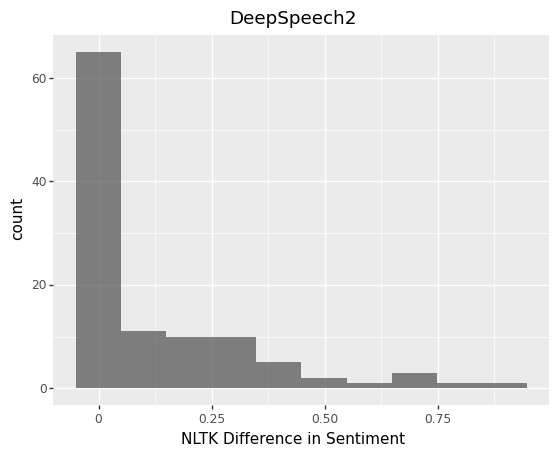

<ggplot: (8789691674043)>

In [173]:
(
    ggplot(measures_ds, aes(x='NLTK_DS'))
    + geom_histogram(measures_ds, aes(x='NLTK_DS'), bins=10, alpha=0.75)
#     + geom_histogram(measures_ds, aes(x='NLTK_DS'), bins=10, alpha=0.5, fill='grey')
#     + geom_histogram(measures_wv, aes(x='NLTK_DS'), bins=10, alpha=0.5, fill='green')
    + xlab("NLTK Difference in Sentiment")
    + ylab("count")
    + ggtitle('DeepSpeech2')
)

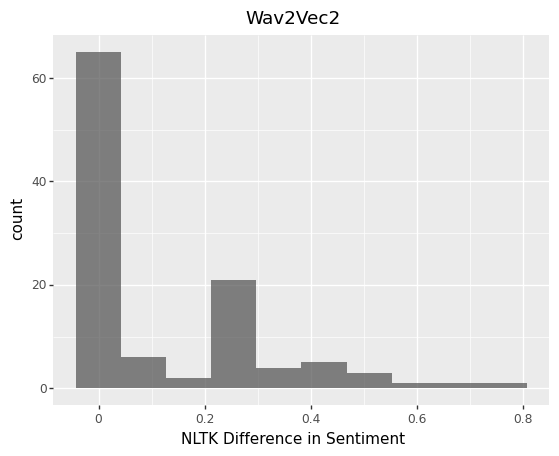

<ggplot: (8789689468507)>

In [175]:
(
    ggplot(measures_wv, aes(x='NLTK_DS'))
    + geom_histogram(measures_wv, aes(x='NLTK_DS'), bins=10, alpha=0.75)
    + xlab("NLTK Difference in Sentiment")
    + ylab("count")
    + ggtitle('Wav2Vec2')
)

In [176]:
# (
#     ggplot(measures_wv, aes(x='NLTK_DS'))
#     + geom_histogram(bins=10)
#     + xlab("NLTK DS")
#     + ylab("count")
# )

In [177]:
# measures_ds

In [203]:
measures_ds['ASR'] = ['DeepSpeech2']*109
measures_wv['ASR'] = ['Wav2Vec2']*109
measures_v['ASR'] = ['Vosk']*109
measures_wh['ASR'] = ['Whisper']*109
measures_ps['ASR'] = ['PocketSphinx']*109

wv_ds_nltk = pd.DataFrame({
    'NLTK_DS': pd.concat([
        measures_ds['NLTK_DS'], 
        measures_wv['NLTK_DS'],
#         measures_v['NLTK_DS'],
#         measures_wh['NLTK_DS']
    ]),
    'ASR': pd.concat([
        measures_ds['ASR'], 
        measures_wv['ASR'],
#         measures_v['ASR'],
#         measures_wh['ASR']
    ])
})

v_wh_nltk = pd.DataFrame({
    'NLTK_DS': pd.concat([
#         measures_ds['NLTK_DS'], 
#         measures_wv['NLTK_DS'],
        measures_v['NLTK_DS'],
        measures_wh['NLTK_DS']
    ]),
    'ASR': pd.concat([
#         measures_ds['ASR'], 
#         measures_wv['ASR'],
        measures_v['ASR'],
        measures_wh['ASR']
    ])
})

In [179]:
asr_nltk

,NLTK_DS,ASR
0,0.0000,DeepSpeech2
1,0.0000,DeepSpeech2
2,0.0000,DeepSpeech2
3,0.0000,DeepSpeech2
4,0.0573,DeepSpeech2
...,...,...
104,0.5574,Whisper
105,0.0000,Whisper
106,0.0000,Whisper
107,0.0000,Whisper


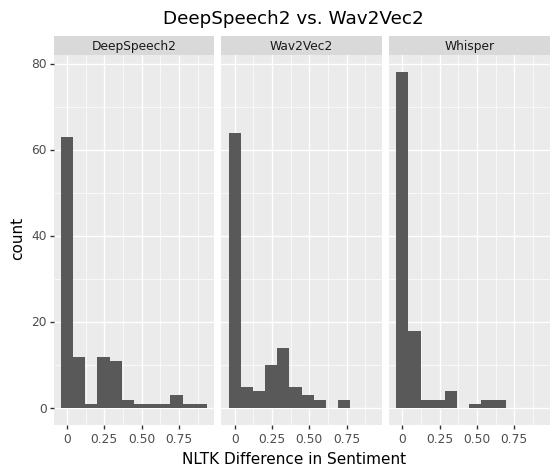

<ggplot: (8789691780012)>

In [180]:
(
    ggplot(asr_nltk, aes(x='NLTK_DS'))
    + facet_grid(facets="~ASR")
    + geom_histogram(bins=12)
#     + geom_histogram(measures_ds, aes(x='NLTK_DS'), bins=10, alpha=0.75)
#     + geom_histogram(measures_ds, aes(x='NLTK_DS'), bins=10, alpha=0.5, fill='grey')
#     + geom_histogram(measures_wv, aes(x='NLTK_DS'), bins=10, alpha=0.5, fill='green')
    + xlab("NLTK Difference in Sentiment")
    + ylab("count")
    + ggtitle('DeepSpeech2 vs. Wav2Vec2')
)

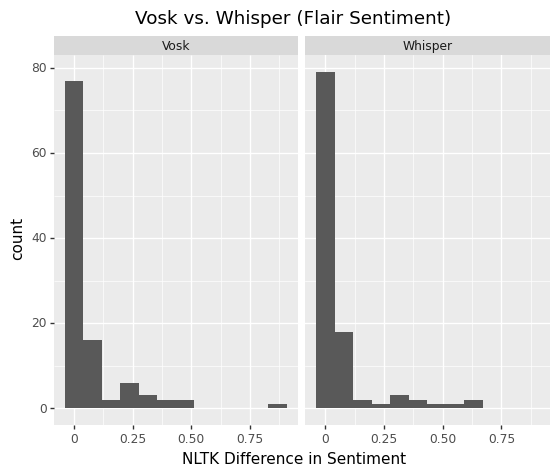

<ggplot: (8789686662867)>

In [182]:
(
    ggplot(v_wh_nltk, aes(x='NLTK_DS'))
    + facet_grid(facets="~ASR")
    + geom_histogram(bins=12)
#     + geom_histogram(measures_ds, aes(x='NLTK_DS'), bins=10, alpha=0.75)
#     + geom_histogram(measures_ds, aes(x='NLTK_DS'), bins=10, alpha=0.5, fill='grey')
#     + geom_histogram(measures_wv, aes(x='NLTK_DS'), bins=10, alpha=0.5, fill='green')
    + xlab("NLTK Difference in Sentiment")
    + ylab("count")
    + ggtitle('Vosk vs. Whisper (Flair Sentiment)')
)

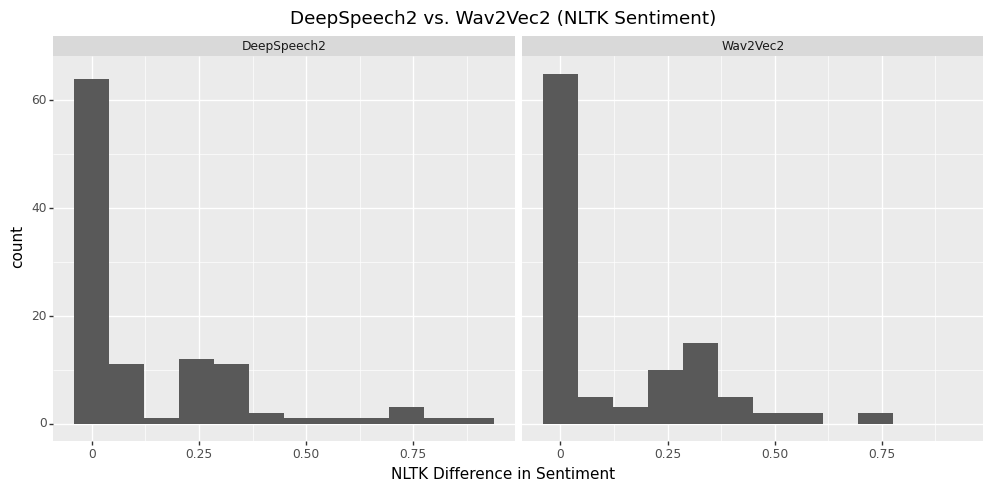

<ggplot: (8789685832024)>

In [183]:
(
    ggplot(wv_ds_nltk, aes(x='NLTK_DS'))
    + facet_grid(facets="~ASR")
    + geom_histogram(bins=12)
#     + geom_histogram(measures_ds, aes(x='NLTK_DS'), bins=10, alpha=0.75)
#     + geom_histogram(measures_ds, aes(x='NLTK_DS'), bins=10, alpha=0.5, fill='grey')
#     + geom_histogram(measures_wv, aes(x='NLTK_DS'), bins=10, alpha=0.5, fill='green')
    + xlab("NLTK Difference in Sentiment")
    + ylab("count")
    + ggtitle('DeepSpeech2 vs. Wav2Vec2 (NLTK Sentiment)')
     + theme(figure_size=(12, 5))  # here you define the plot size

)

## Look at most sever errors

In [206]:
all_concat = pd.concat([
    measures_ds,
    measures_ps,
    measures_v,
    measures_wh,
    measures_wv,
])

In [ ]:
# measures_v.head()
# measures_ps.head()
# measures_wh.head()
# measures_ds.head()
measures_wv

### most severe according to FLAIR w/WER < 0.5

In [261]:
top_fl = all_concat[all_concat['WER'] < 0.5][['pairs', 'FLAIR_DS', 'DisRob', 'WER', 'ASR']].sort_values('FLAIR_DS', ascending=False)
top_fl.head(50).round(3)


,pairs,FLAIR_DS,DisRob,WER,ASR
9,"(when you were doing that, when you redurin that)",1.996,0.579,0.400,Wav2Vec2
73,(i'd say it's worse when i when i walk more th...,1.986,0.613,0.487,DeepSpeech2
50,"(i do take umm, i do take em)",1.959,0.261,0.250,Vosk
23,"(uh i smoke about a pack a day, uh smoke abou...",1.929,0.170,0.250,Whisper
82,(what brings you here today i'm just having th...,1.914,0.168,0.440,Whisper
88,"(that you're experiencing some chest pain, tha...",1.889,0.460,0.333,Vosk
66,"(and how often do you use crystal meth, and ho...",1.858,0.388,0.125,Whisper
22,"(ok sounds like a a pretty stressful job, and ...",1.850,0.216,0.375,DeepSpeech2
75,(yeah i guess i'd say i have this frothy sputu...,1.832,0.374,0.200,Whisper
93,(yeah i just feel it in that one spot on the l...,1.825,0.488,0.385,DeepSpeech2


In [262]:
for r in top_fl.head(50)['pairs']:
    print(r)

('when you were doing that', 'when you redurin that')
("i'd say it's worse when i when i walk more than fifty meters that's kind of the main like that's kind of the main trigger just exertion ok and were you able to walk normally more than fifty meters", "oh i say worth when i when i walk more than fifty meters that's canaanites come man trituration and were you able to walk on normally more than fifty meters")
('i do take umm', 'i do take em')
('uh i smoke about a pack a day', ' uh smoke about a pack of day')
("what brings you here today i'm just having this really sharp pain in my chest and i'm scared i think i'm having a heart attack", " what brings you here today i'm just having this really sharp bean in my chest and i'm scared i think i'm having a heart attack oh wow i'm you know that must be really scary")
("that you're experiencing some chest pain", "that you're experiencing some chatting")
('and how often do you use crystal meth', 'and how often do you use crystal mud')
('ok so

In [290]:
# all_concat

### most severe according to DisRob w/WER < 0.5

In [291]:
top_sev_emb = all_concat[all_concat['WER'] < 0.5][['pairs', 'FLAIR_DS', 'MiniLM', 'WER', 'ASR']].sort_values('MiniLM', ascending=False)
top_sev_emb.head(50)


,pairs,FLAIR_DS,MiniLM,WER,ASR
36,(nothing has seemed to make it any better sinc...,0.003337,0.692217,0.363636,Wav2Vec2
56,(have you at all in the past been hospitalized...,1.773090,0.565104,0.416667,DeepSpeech2
45,(have you been having any kind of thumping or ...,0.108115,0.551029,0.450000,DeepSpeech2
81,"(what they did for your heart attack, what the...",1.616888,0.545719,0.142857,Wav2Vec2
36,(nothing has seemed to make it any better sinc...,0.011287,0.545543,0.272727,Whisper
32,"(it feels dull i feel like there's, if yours d...",0.454013,0.538671,0.428571,Vosk
66,"(and how often do you use crystal meth, and ho...",0.009822,0.512011,0.250000,Vosk
73,(i'd say it's worse when i when i walk more th...,1.986485,0.507500,0.487179,DeepSpeech2
9,"(when you were doing that, when you redurin that)",1.995775,0.495077,0.400000,Wav2Vec2
67,"(i would say a, i would say a few)",0.097243,0.487106,0.250000,Whisper


In [292]:
for r in top_sev_emb.head(50)['pairs']:
    print(r)

('nothing has seemed to make it any better since it starting', 'dorthins seemed to make him any better since the starting')
('have you at all in the past been hospitalized for any reason', 'have you at all in the past in contained person')
('have you been having any kind of thumping or palpitations or feel like your heart has been racing at all', 'have you been having any kind of thing position or feel like your hearthstone')
('what they did for your heart attack', 'what they did for your herd attack')
('nothing has seemed to make it any better since it starting', "dawthing has seemed to make you any better since it's starting")
("it feels dull i feel like there's", "if yours die i feel like there's")
('and how often do you use crystal meth', 'and how often do you use for sunlight')
("i'd say it's worse when i when i walk more than fifty meters that's kind of the main like that's kind of the main trigger just exertion ok and were you able to walk normally more than fifty meters", "oh i

### most severe according to WER w/cosine dis < 0.5

In [282]:
top_sev_wer = all_concat[all_concat['DisRob'] < 0.5][['pairs', 'FLAIR_DS', 'DisRob', 'WER', 'ASR']].sort_values(
    ['WER', 'DisRob'], ascending=[False, True])
top_sev_wer.head(50)

,pairs,FLAIR_DS,DisRob,WER,ASR
54,"(a multivitamin, a multi vitamin)",0.000497,0.084387,1.000000,DeepSpeech2
54,"(a multivitamin, a multi vitamin)",0.000497,0.084387,1.000000,Vosk
17,"(ok, okay)",1.094372,0.181010,1.000000,DeepSpeech2
48,"(ok, okay)",1.094372,0.181010,1.000000,DeepSpeech2
55,"(ok, okay)",1.094372,0.181010,1.000000,DeepSpeech2
17,"(ok, okay)",1.094372,0.181010,1.000000,Vosk
48,"(ok, okay)",1.094372,0.181010,1.000000,Vosk
55,"(ok, okay)",1.094372,0.181010,1.000000,Vosk
96,"(ok, okay)",1.094372,0.181010,1.000000,Vosk
17,"(ok, okay)",1.094372,0.181010,1.000000,Whisper


In [283]:
for r in top_sev_wer.head(50)['pairs']:
    print(r)

('a multivitamin', 'a multi vitamin')
('a multivitamin', 'a multi vitamin')
('ok', 'okay')
('ok', 'okay')
('ok', 'okay')
('ok', 'okay')
('ok', 'okay')
('ok', 'okay')
('ok', 'okay')
('ok', 'okay')
('ok', 'okay')
('ok', 'okay')
('ok', 'okay')
('um not laying down helps', "i'm not laying down i'm not laying down")
('my parents', 'our friends')
('tell me', 'tell you that')
("i've tried uh", "i'e tried i ad")
('uh', 'ah')
('uh', 'ah')
("yeah i'm i'm just feeling this", 'y i jus feeling this and')
('um producing like sputum or phlegm', 'currently producing like spewed and more flam')
('sore throat runny nose uh', 'i saw the runny nose')
("uh yep that's about it ok and uh how do you support yourself financially", 'so n yo at thea edge o care an and a how do you support yourself a financially')
('uh thirty eight degrees', '38 degrees')
("but it's becoming sharper", "ah but it's the coming sharper")
('uh thirty eight degrees', 'the degrees')
('or like get better', 'where can i get better')
("i 

sentiment

In [217]:
all_concat[['pairs', 'FLAIR_DS', 'MPNET', 'WER', 'ASR']].sort_values('FLAIR_DS', ascending=False).head(15)

,pairs,FLAIR_DS,MPNET,WER,ASR
54,"(a multivitamin, a a multy biteman)",1.998913,0.703994,1.500000,Wav2Vec2
74,"(um producing like sputum or phlegm, producing...",1.998621,0.818778,0.833333,DeepSpeech2
88,"(that you're experiencing some chest pain, tha...",1.997706,0.733470,1.000000,PocketSphinx
11,"(have you been sweaty at all, have you been so...",1.997408,0.270325,0.500000,PocketSphinx
9,"(when you were doing that, when you redurin that)",1.995775,0.411737,0.400000,Wav2Vec2
80,"(sore throat runny nose uh, exactly letting y...",1.994096,0.912578,1.000000,Whisper
27,(it's just right over on the on the left side...,1.994042,0.890110,1.000000,PocketSphinx
74,"(um producing like sputum or phlegm, i'm the r...",1.993989,0.969877,1.166667,PocketSphinx
35,"(it made it a bit worse but, made it a awards)",1.993304,0.756746,0.571429,DeepSpeech2
7,(maybe taking a deep breath yeah ok and when t...,1.992351,0.936278,1.214286,PocketSphinx


by MPNET

In [221]:
all_concat[['pairs', 'FLAIR_DS', 'MPNET', 'WER', 'ASR']].sort_values('MPNET', ascending=False).head(15)

,pairs,FLAIR_DS,MPNET,WER,ASR
63,"(about a half a pack to a pack a day, don't as...",1.737715,1.083589,1.000000,PocketSphinx
53,"(rosuvastatin and, i agree to the sound and)",0.005509,1.028533,2.500000,PocketSphinx
95,(about the same ok and has it gotten more freq...,1.901096,1.015895,1.000000,PocketSphinx
24,(for the past ten to fifteen years ok and do y...,0.133668,1.009247,0.846154,PocketSphinx
15,"(no ok have you had any nausea or vomiting , y...",1.700998,1.002993,0.888889,PocketSphinx
10,(i'd say it's like a seven or eight it's prett...,0.009263,1.002567,0.869565,PocketSphinx
56,(have you at all in the past been hospitalized...,0.416315,0.996730,1.000000,PocketSphinx
12,"(uh um, i'm not either)",0.304075,0.994405,1.500000,PocketSphinx
26,"(ok and where is the pain exactly, and and wel...",1.989838,0.993158,1.000000,PocketSphinx
68,"(a couple of times a month, and looks as it was)",0.122134,0.991519,1.000000,PocketSphinx


In [242]:
all_concat[all_concat['WER'] < 0.5][['pairs', 'FLAIR_DS', 'MPNET', 'WER', 'ASR']].sort_values('MPNET', ascending=False).head(15)

# for r in all_concat[all_concat['WER'] < 0.5][['pairs', 'FLAIR_DS', 'MPNET', 'WER', 'ASR']].sort_values('MPNET', ascending=False).head(15)['pairs']:
#     print(r)



,pairs,FLAIR_DS,MPNET,WER,ASR
67,"(i would say a, i would say a few)",0.097243,0.769672,0.250000,Whisper
81,"(what they did for your heart attack, what the...",1.616888,0.688345,0.142857,Wav2Vec2
65,"(but i have used crystal meth in the past, i h...",0.001269,0.685024,0.444444,DeepSpeech2
32,"(it feels dull i feel like there's, if yours d...",0.454013,0.647151,0.428571,Vosk
66,"(and how often do you use crystal meth, and ho...",0.009822,0.613196,0.250000,Vosk
36,(nothing has seemed to make it any better sinc...,0.003337,0.613081,0.363636,Wav2Vec2
45,(have you been having any kind of thumping or ...,0.108115,0.583977,0.450000,DeepSpeech2
40,(ok so but the pain just started half an hour ...,0.011924,0.560659,0.272727,Vosk
30,(sorry yeah the pain has been there this whole...,0.000918,0.550044,0.105263,Whisper
42,"(no nausea or vomiting but, no progress 좋아하 v...",0.424263,0.524712,0.400000,Whisper


In [237]:
all_concat[all_concat['DisRob'] < 0.5][['pairs', 'FLAIR_DS', 'DisRob', 'WER', 'ASR']].sort_values('WER', ascending=False).head(50)


,pairs,FLAIR_DS,DisRob,WER,ASR
60,"(my parents, our friends)",0.004587,0.372411,1.000000,PocketSphinx
104,"(i've tried uh, i'e tried i ad)",0.041493,0.482583,1.000000,Wav2Vec2
91,"(uh, ah)",0.216465,0.489109,1.000000,DeepSpeech2
8,"(tell me, tell you that)",0.281974,0.468412,1.000000,PocketSphinx
91,"(uh, ah)",0.216465,0.489109,1.000000,Wav2Vec2
48,"(ok, okay)",1.094372,0.181010,1.000000,Vosk
96,"(ok, okay)",1.094372,0.181010,1.000000,Whisper
96,"(ok, okay)",1.094372,0.181010,1.000000,Vosk
55,"(ok, okay)",1.094372,0.181010,1.000000,DeepSpeech2
54,"(a multivitamin, a multi vitamin)",0.000497,0.084387,1.000000,DeepSpeech2


In [193]:
# measures_v.head()
# measures_ps.head()
# measures_wh.head()
# measures_ds.head()
measures_wv[['pairs', 'FLAIR_DS', 'WER']].sort_values('FLAIR_DS', ascending=False).head(10)

,pairs,FLAIR_DS,WER,MPNET
54,"(a multivitamin, a a multy biteman)",1.998913,1.500000,0.703994
9,"(when you were doing that, when you redurin that)",1.995775,0.400000,0.411737
74,"(um producing like sputum or phlegm, co produc...",1.991294,0.666667,0.650687
23,"(uh i smoke about a pack a day, a smoke about ...",1.933803,0.500000,0.307447
51,"(medications for, metications for)",1.933646,0.500000,0.564642
82,(what brings you here today i'm just having th...,1.914841,0.600000,0.208593
22,"(ok sounds like a a pretty stressful job, o ga...",1.892463,0.625000,0.270928
100,"(to my health or, to my houth for an)",1.840583,0.750000,0.601563
107,"(previously healthy, and previously healthy)",1.771463,0.500000,0.157640
89,"(yeah so, yes o am)",1.749879,1.500000,0.733086


In [199]:
measures_v[['pairs', 'FLAIR_DS', 'WER']].sort_values('FLAIR_DS', ascending=False).head(10)

,pairs,FLAIR_DS,WER
53,"(rosuvastatin and, i received a satin and)",1.987282,2.000000
50,"(i do take umm, i do take em)",1.958845,0.250000
88,"(that you're experiencing some chest pain, tha...",1.889083,0.333333
107,"(previously healthy, in previously healthy)",1.763430,0.500000
104,"(i've tried uh, i have tried add)",1.733149,1.000000
82,(what brings you here today i'm just having th...,1.729851,0.480000
2,"(uhm it started last night, and it started las...",1.706749,0.200000
64,"(uh no alcohol, a no alcohol)",1.627436,0.333333
91,"(uh, a)",1.604215,1.000000
98,"(i don't know i've, i dunno i)",1.581106,0.750000


In [201]:
for r in measures_v[['pairs', 'FLAIR_DS', 'WER']].sort_values('FLAIR_DS', ascending=False).head(10)['pairs']:
    print(r)

('rosuvastatin and', 'i received a satin and')
('i do take umm', 'i do take em')
("that you're experiencing some chest pain", "that you're experiencing some chatting")
('previously healthy', 'in previously healthy')
("i've tried uh", 'i have tried add')
("what brings you here today i'm just having this really sharp pain in my chest and i'm scared i think i'm having a heart attack", "what brings you here today as having this really sharp pain in my chest and i'm scared i think i'm having a heart attack a while from you and i must be really scary")
('uhm it started last night', 'and it started last night')
('uh no alcohol', 'a no alcohol')
('uh', 'a')
("i don't know i've", 'i dunno i')


In [185]:
measures_wv.head()


,pairs,WER,NLTK_DS,FLAIR_DS,TB_DS,MiniLM,BertNLI,MPNET,DisRob,ASR
0,"(sure thirty nine i'm a male, sharp am thirty ...",0.500000,0.3182,0.004336,0.3125,0.270068,3.961635e-02,3.800907e-01,4.233803e-01,Wav2Vec2
1,"(start, start)",0.000000,0.0000,0.000000,0.0000,0.000000,1.192093e-07,-3.576279e-07,-2.384186e-07,Wav2Vec2
2,"(uhm it started last night, and it started las...",0.200000,0.0000,1.706749,0.0000,0.137907,9.372473e-03,1.710131e-01,1.264330e-01,Wav2Vec2
3,"(but it's becoming sharper, ah but it's the co...",0.750000,0.0000,0.009317,0.4500,0.212036,7.231593e-02,2.057103e-01,2.384362e-01,Wav2Vec2
4,"(ok and where is this pain located , o ka and ...",0.571429,0.1990,0.000587,0.5000,0.246935,8.226669e-02,1.162727e-01,3.469793e-01,Wav2Vec2


text embeddings

In [196]:
measures_wv[['pairs', 'MPNET', 'WER']].sort_values('MPNET', ascending=False).head(30)

,pairs,MPNET,WER
67,"(i would say a, would tay it if you)",0.958250,1.250000
69,"(a couple times a month okay, ofo fendemon or ...",0.950688,1.000000
53,"(rosuvastatin and, i resue i satin and)",0.893536,2.000000
37,"(okay, oquery)",0.882507,1.000000
79,"(and, hand)",0.881021,1.000000
87,"(it sounds like uh, t found flake ab)",0.867295,1.000000
96,"(ok, pa)",0.844274,1.000000
8,"(tell me, ta a)",0.838895,1.000000
78,"(okay, propane)",0.837193,1.000000
39,"(but, bu)",0.828141,1.000000


In [198]:
for r in measures_wv[['pairs', 'MPNET', 'WER']].sort_values('MPNET', ascending=False).head(30)['pairs']:
    print(r)

('i would say a', 'would tay it if you')
('a couple times a month okay', 'ofo fendemon or gat')
('rosuvastatin and', 'i resue i satin and')
('okay', 'oquery')
('and', 'hand')
('it sounds like uh', 't found flake ab')
('ok', 'pa')
('tell me', 'ta a')
('okay', 'propane')
('but', 'bu')
('uh um', 'ma an')
('ok', 'poe')
('ok', 'poge')
('so two weeks', 'though two leaks')
('a little runny but that went away on its own', 'alli varandi pit a that went away on it all and')
('no hospitalizations', 'no osplizations')
('i do take umm', 'i do think yam')
('uh both blood pressure and cholesterol', 'ah both blood pressere and colesterall')
('yeah so', 'yes o am')
('high blood pressure', 'i brought pressure')
('a multivitamin', 'a a multy biteman')
('what they did for your heart attack', 'what they did for your herd attack')
("i don't know i've", 'i no o i')
('um producing like sputum or phlegm', 'co producing like putom orflam')
("uh i'm an accountant", "ah i'm a acounten's")
('okay and', 'look and')

In [187]:
measures_ds[['pairs', 'DisRob', 'WER']].sort_values('DisRob', ascending=False).head(15)

,pairs,DisRob,WER
80,"(sore throat runny nose uh, so trains)",0.921088,1.000000
78,"(okay, a)",0.916241,1.000000
37,"(okay, a)",0.916241,1.000000
40,(ok so but the pain just started half an hour ...,0.884119,0.818182
21,"(uh i'm an accountant, ah i nicotine)",0.877527,1.000000
49,"(high blood pressure, a bookcase)",0.874717,1.000000
75,(yeah i guess i'd say i have this frothy sputu...,0.869429,0.600000
15,"(no ok have you had any nausea or vomiting , n...",0.858533,1.000000
74,"(um producing like sputum or phlegm, producing...",0.842224,0.833333
12,"(uh um, a)",0.814017,1.000000


In [191]:
# for r in measures_wh[['pairs', 'DisRob']].sort_values('DisRob', ascending=False).head(10)['pairs']:
#     print(r)
measures_wh[['WER','FLAIR_DS', 'DisRob']].sort_values('DisRob', ascending=False).head(15).round(3)

,WER,FLAIR_DS,DisRob
80,1.000,1.994,0.919
69,1.000,1.704,0.861
21,1.000,1.617,0.835
79,1.000,0.035,0.829
91,1.000,1.652,0.771
12,1.000,1.681,0.709
50,0.500,0.454,0.681
74,0.833,0.201,0.672
27,0.400,0.000,0.631
67,0.250,0.097,0.624


In [115]:
# measures_wv[['pairs', 'MPNET']].sort_values('MPNET', ascending=False).head(10)

In [190]:
for r in measures_wh[['pairs', 'DisRob']].sort_values('DisRob', ascending=False).head(15)['pairs']:
    print(r)

('sore throat runny nose uh', ' exactly letting you know')
('a couple times a month okay', ' up to the central nodes ok')
("uh i'm an accountant", "i'm gonna count in")
('and', 'kel')
('uh', 'dad')
('uh um', "i'm")
('i do take umm', ' i do think um')
('um producing like sputum or phlegm', ' kind of producing like spudon north lem')
("it's just right  over on the on the left side", 'and just radio over on the left side')
('i would say a', 'i would say a few')
('a little runny but that went away on its own', 'all of our money but uh that went away on its own')
('rosuvastatin and', 'uh resubistatin and')
("sorry yeah the pain has been there this whole time and it's gotten worse ever since it started ok", " sorry yeah the paint has been there this whole time and it's gotten worse ever since it started okay")
("that you're experiencing some chest pain", "that you're experiencing some testing")
('no nausea or vomiting but', ' no progress 좋아하 vomiting but')


In [135]:
# measures_wh

,pairs,WER,NLTK_DS,FLAIR_DS,TB_DS,MiniLM,BertNLI,MPNET,DisRob,ASR
0,"(sure thirty nine i'm a male, sure 39 i'm a m...",0.333333,0.0000,1.742313,0.0,2.097204e-01,9.452528e-02,1.723946e-01,1.668972e-01,Whisper
1,"(start, start)",0.000000,0.0000,0.000000,0.0,0.000000e+00,1.192093e-07,-3.576279e-07,-2.384186e-07,Whisper
2,"(uhm it started last night, it started last ni...",0.200000,0.0000,1.507091,0.0,5.841285e-02,1.290882e-02,5.778933e-02,4.433155e-02,Whisper
3,"(but it's becoming sharper, but it's becoming ...",0.000000,0.0000,0.000000,0.0,-2.384186e-07,-2.384186e-07,3.576279e-07,3.576279e-07,Whisper
4,"(ok and where is this pain located , okay and...",0.142857,0.0573,0.000259,0.0,2.560210e-02,2.129674e-03,1.643854e-02,1.518667e-02,Whisper
...,...,...,...,...,...,...,...,...,...,...
104,"(i've tried uh, i've tried died whose)",0.666667,0.5574,0.113616,0.0,4.485447e-01,3.461263e-01,6.637155e-01,4.289226e-01,Whisper
105,(do you have any chronic conditions that you s...,0.076923,0.0000,1.306630,0.0,1.842076e-02,5.282336e-02,6.401187e-02,4.139620e-02,Whisper
106,"(no um, no)",0.500000,0.0000,0.092537,0.0,2.390673e-01,9.095550e-03,3.788630e-01,3.816152e-01,Whisper
107,"(previously healthy, and previously healthy)",0.500000,0.0000,1.771463,0.0,1.630079e-01,1.754385e-02,1.576399e-01,3.202252e-01,Whisper


In [192]:
wer("sorry yeah the pain has been there this whole time and it's gotten worse ever since it started ok", 
    " sorry yeah the paint has been there this whole time and it's gotten worse ever since it started okay")

0.10526315789473684

In [256]:
wer('a multivitamin', 'a multi vitamin')

1.0

In [247]:
from jiwer import cer

ground_truth = ["i can spell", "i hope"]
hypothesis = ["i kan cpell", "i hop"]

In [249]:
cer('a multivitamin','a multi vitamin')

0.07142857142857142

In [255]:
from Levenshtein import distance
# distance("lewenstein", "levenshtein")
distance('a multivitamin','a multi vitamin') / 2

0.5

In [239]:
all_concat.corr()

/var/folders/45/q82ywkcn7fnbcgzp5x_lv4880000gn/T/ipykernel_28540/3031258403.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,WER,NLTK_DS,FLAIR_DS,TB_DS,MiniLM,BertNLI,MPNET,DisRob
WER,1.000000,0.309193,0.419380,0.346006,0.787080,0.600384,0.784905,0.803772
NLTK_DS,0.309193,1.000000,0.097368,0.422243,0.379973,0.389757,0.364998,0.380941
FLAIR_DS,0.419380,0.097368,1.000000,0.170764,0.413155,0.314370,0.416989,0.434114
TB_DS,0.346006,0.422243,0.170764,1.000000,0.380843,0.352637,0.368818,0.395430
MiniLM,0.787080,0.379973,0.413155,0.380843,1.000000,0.781671,0.972011,0.970134
BertNLI,0.600384,0.389757,0.314370,0.352637,0.781671,1.000000,0.774224,0.774227
MPNET,0.784905,0.364998,0.416989,0.368818,0.972011,0.774224,1.000000,0.973293
DisRob,0.803772,0.380941,0.434114,0.395430,0.970134,0.774227,0.973293,1.000000
